In [1]:
import pandas as pd
import numpy as np


CDI = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_cleaned.csv")
similarity_matrix = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/nouns.csv")

# Set index for similarity matrix
similarity_matrix = similarity_matrix.set_index('Unnamed: 0')

In [3]:
# Define the word columns (excluding metadata columns)
metadata_cols = ['child_id', 'study id', 'study', 'gender', 'age', 'birthday', 'session_date', 'session_num', 'total num sessions', 'words_spoken', 'items excluded', 'percentile', 'extra categories', 'revision', 'languages', 'num languages', 'cdi type', 'hard of hearing', 'deleted', 'vocab_size', 'Late_Talker', 'Persistent_Late_Talker', 'vocab_zscore', 'trajectory_slope']
unnamed_cols = [col for col in CDI.columns if col.startswith('Unnamed')]
exclude_cols = set(metadata_cols + unnamed_cols)
word_cols = [col for col in CDI.columns if col not in exclude_cols]

print(f"Number of word columns: {len(word_cols)}")


# Create a list of known words for each child at each session
known_words_list = []
for idx, row in CDI.iterrows():
    child = row['child_id']
    session = row['session_num']
    known = [col for col in word_cols if row[col] == 1]
    known_words_list.append({'child_id': child, 'session_num': session, 'known_words': known, 'num_known': len(known)})

# Convert to DataFrame
known_words_df = pd.DataFrame(known_words_list)

# Display the first few rows
known_words_df.head(100)

Number of word columns: 680


,child_id,session_num,known_words,num_known
0,4139,1,"[baa baa, moo, yum yum, bear, bird, cat, dog, ...",94
1,4139,2,"[baa baa, grr, meow, moo, ouch, uh oh, vroom, ...",164
2,4139,3,"[baa baa, choo choo, grr, meow, moo, ouch, uh ...",204
3,4139,4,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",230
4,4139,5,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",268
...,...,...,...,...
95,4250,3,"[quack quack, woof woof, dog, goose, kitty, tr...",16
96,4250,4,"[quack quack, woof woof, dog, goose, kitty, tr...",21
97,4250,5,"[choo choo, quack quack, uh oh, woof woof, bee...",37
98,4250,6,"[choo choo, grr, meow, moo, quack quack, uh oh...",57


Graph built with 94 nodes and 651 edges


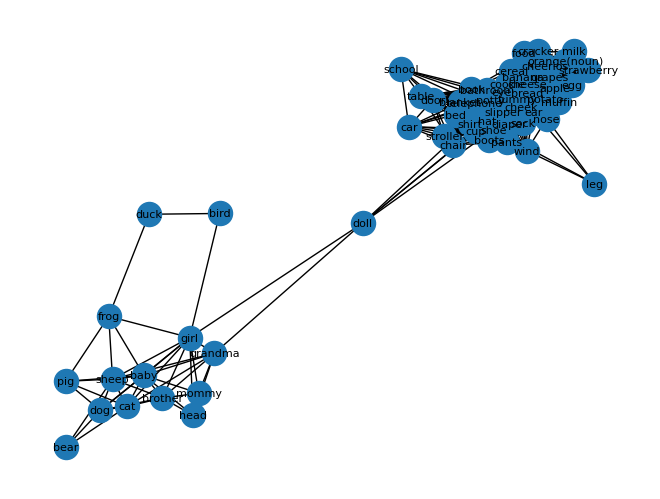

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

# Select a child and session
selected_child = 4139  # Change this to the desired child ID
selected_session = 1  # Change this to the desired session number

# Get known words for the selected child and session
known_words = known_words_df[(known_words_df['child_id'] == selected_child) & (known_words_df['session_num'] == selected_session)]['known_words'].iloc[0]


# Build the graph
G = nx.Graph()
G.add_nodes_from(known_words)

edges_added = 0
for i, word_i in enumerate(known_words):
    for j, word_j in enumerate(known_words[i+1:], start=i+1):
        if word_i in similarity_matrix.index and word_j in similarity_matrix.columns:
            sim = similarity_matrix.loc[word_i, word_j]
            if sim > 0.5:  # Adjust threshold as needed
                G.add_edge(word_i, word_j, weight=sim) #weighted for now
                edges_added += 1

print(f"Graph built with {len(known_words)} nodes and {edges_added} edges")

# Plot the graph - for the graph, I removed non-connected nodes because they were dominating the graph
G_plot = G.copy() 
isolates = list(nx.isolates(G_plot))
G_plot.remove_nodes_from(isolates)

pos = nx.spring_layout(G_plot, seed=42)
nx.draw(G_plot, pos, with_labels=True, font_size=8, node_size=300)
plt.show()




Statistics on the child's graph

In [ ]:
#basic counts
num_words = G.number_of_nodes()                                     # total number of words known at this session
num_isolate_words = nx.number_of_isolates(G)                        # number of words with no connections
num_connected_words = num_words - num_isolate_words                 # number of words with at least one connection           

#degree                                                             # number of edges connected to a node                            
weighted_degree = dict(G.degree(weight='weight'))                   # calculates number of edges per node
unweighted_degree = dict(G.degree())                                # calculates number of weighted edges per node CHAT: sum(weights)?

avg_weighted_degree = np.mean(list(weighted_degree.values()))       #average across all CHAT: known nodes at this time session? 
avg_unweighted_degree = np.mean(list(unweighted_degree.values()))   # is it common practice to average nodes with a degree 0? 

#betweenness - counting each degree as a distance of 1
betweenness = nx.betweenness_centrality(G, normalized=True)         # measures how often a node lies on the shortest path between other nodes. Normalized, so 
avg_betweenness = np.mean(list(betweenness.values()))

#clustering coeff
avg_clustering = nx.average_clustering(G, weight='weight')

#average shortest path length
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)
avg_shortest_path = nx.average_shortest_path_length(subgraph)


print(f"Number of words: {num_words}")
print(f"Number of isolated words: {num_isolate_words}")
print(f"Number of connected words: {num_connected_words}\n")

print(f"Average weighted degree: {avg_weighted_degree:.2f}")
print(f"Average unweighted degree: {avg_unweighted_degree:.2f}\n")

print(f"Average betweenness centrality: {avg_betweenness:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Average shortest path length: {avg_shortest_path:.4f}")


Number of words: 94
Number of isolated words: 35
Number of connected words: 59

Average weighted degree: 8.17
Average unweighted degree: 13.85

Average betweenness centrality: 0.0059
Average clustering coefficient: 0.3514
Average shortest path length: 2.3951


In [45]:
print(num_words)
print(num_connected_words)
print(betweenness)
251 + 226

94
59
{'baa baa': 0.0, 'moo': 0.0, 'yum yum': 0.0, 'bear': 0.0, 'bird': 0.005742558828112827, 'cat': 0.0077825945287375775, 'dog': 0.004079894314817175, 'duck': 0.00015583606046439146, 'fish(animal)': 0.0, 'frog': 0.008787205859435874, 'pig': 0.00021037868162692848, 'sheep': 0.008733194497570373, 'car': 0.0004247966204487943, 'stroller': 0.0003400917908424049, 'ball': 0.0, 'balloon': 0.0, 'book': 0.003377979513036784, 'doll': 0.14399251986909772, 'apple': 0.0016234319628225598, 'banana': 0.002792322384683655, 'bread': 0.003705891072635496, 'cereal': 0.002016096482790376, 'cheerios': 0.0011281306123897131, 'cheese': 0.0032061686351705335, 'cookie': 0.006608412636312044, 'cracker': 0.00027850815031284763, 'egg': 0.0004359582911102741, 'food': 0.0013591227800291586, 'grapes': 0.001555990919940458, 'milk': 0.00010049301108850166, 'muffin': 0.0016019554479254797, 'orange(noun)': 0.0002009935763074755, 'potato': 0.002410498574810874, 'strawberry': 5.273529786771269e-05, 'water(food)': 0.0, '

477

Number of word columns: 680


,child_id,session_num,known_words,num_known
0,4139,1,"[baa baa, moo, yum yum, bear, bird, cat, dog, ...",94
1,4139,2,"[baa baa, grr, meow, moo, ouch, uh oh, vroom, ...",164
2,4139,3,"[baa baa, choo choo, grr, meow, moo, ouch, uh ...",204
3,4139,4,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",230
4,4139,5,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",268
5,4139,6,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",319
6,4139,7,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",375
7,4139,8,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",426
8,4139,9,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",454
9,4139,12,"[baa baa, choo choo, grr, meow, moo, ouch, qua...",477
